# Project Planing

When starting any project, I like to outline the steps that I plan to take. Below is the rough outline that I created for this project using commented cells.

#### Understand nature of the data .info() .describe()
#### Histograms and boxplots 
#### Value counts 
#### Missing data 
#### Correlation between the metrics 
#### Explore interesting themes 
    # Wealthy survive? 
    # By location 
    # Age scatterplot with ticket price 
    # Young and wealthy Variable? 
    # Total spent? 
#### Feature engineering 
#### preprocess data together or use a transformer? 
    # use label for train and test   
#### Scaling?

#### Model Baseline 
#### Model comparison with CV 

## Data Preprocessing for Model 
### 1) Drop null values from Embarked (only 2) 

### 2) Include only relevant variables (Since we have limited data, I wanted to exclude things like name and passanger ID so that we could have a reasonable number of features for our models to deal with) 
Variables:  'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'

### 3) Do categorical transforms on all data. Usually we would use a transformer, but with this approach we can ensure that our traning and test data have the same colums. We also may be able to infer something about the shape of the test data through this method. I will stress, this is generally not recommend outside of a competition (use onehot encoder). 

### 4) Impute data with mean for fare and age (Should also experiment with median) 

### 5) Normalized fare using logarithm to give more semblance of a normal distribution 

### 6) Scaled data 0-1 with standard scaler 



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} missingno

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

Solving environment: done

## Package Plan ##

  environment location: /Users/taa/opt/anaconda3

  added / updated specs:
    - missingno


The following NEW packages will be INSTALLED:

  missingno          pkgs/main/noarch::missingno-0.4.2-pyhd3eb1b0_1

The following packages will be UPDATED:

  conda                               4.10.1-py38hecd8cb5_1 --> 4.11.0-py38hecd8cb5_0


Preparing transaction: done
Verifying transaction: failed

EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: /Users/taa/opt/anaconda3
  uid: 1163210130
  gid: 721532113




# A Glimpse of the datasets.
> **Sample Train Dataset**

In [2]:
## Import Trainning data. 
train = pd.read_csv("cosc2789-2021/cleaned_train.csv")
VALIDATION = pd.read_csv('cosc2789-2021/cleaned_validation.csv')
test = pd.read_csv("cosc2789-2021/cleaned_test.csv")
test.head(3)

,ID,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Side,City,County,State,...,Astronomical_Twilight,Start_Time_Month,Start_Time_Year,Start_Time_Hour,End_Time_Month,End_Time_Year,End_Time_Hour,Weather_Timestamp_Month,Weather_Timestamp_Year,Weather_Time_Hour
0,A-2716608,39.775650,-84.186030,39.772750,-84.188050,0.227,R,Dayton,Montgomery,OH,...,Day,2,2016,8,2,2016,14,2,2016,8
1,A-2716609,41.375310,-81.820170,41.367860,-81.821740,0.521,R,Cleveland,Cuyahoga,OH,...,Day,2,2016,11,2,2016,17,2,2016,11
2,A-2716615,39.582242,-83.677814,39.603013,-83.637319,2.590,R,Jamestown,Greene,OH,...,Day,2,2016,17,2,2016,23,2,2016,17


> **Sample Test Dataset**

# Describe the Datasets

In [3]:
# For example max HP is 255 or min defense is 5
train.describe() #ignore null entries

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Precipitation(in),Start_Time_Month,Start_Time_Year,Start_Time_Hour,End_Time_Month,End_Time_Year,End_Time_Hour,Weather_Timestamp_Month,Weather_Timestamp_Year,Weather_Time_Hour
count,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,...,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000
mean,2.243615,36.924992,-98.719154,36.925070,-98.719007,0.586301,59.671724,64.663488,29.568323,9.161630,...,0.005713,7.681851,2018.894274,12.546825,7.685297,2018.894438,12.717370,7.681824,2018.894274,12.268894
std,0.612126,5.156410,18.477496,5.156403,18.477345,1.630518,18.140203,22.951424,0.999707,2.861522,...,0.104330,3.649626,1.365008,6.152619,3.651002,1.364907,7.029786,3.649635,1.365008,6.085492
min,1.000000,24.570222,-124.497567,24.570110,-124.497478,0.000000,-89.000000,1.000000,0.300000,0.060000,...,0.000000,1.000000,2016.000000,0.000000,1.000000,2016.000000,0.000000,1.000000,2016.000000,0.000000
25%,2.000000,33.858560,-118.214156,33.858335,-118.214103,0.000000,48.000000,49.000000,29.470000,10.000000,...,0.000000,4.000000,2018.000000,8.000000,4.000000,2018.000000,7.000000,4.000000,2018.000000,7.000000
50%,2.000000,37.354780,-94.525898,37.354760,-94.525877,0.178000,61.000000,68.000000,29.880000,10.000000,...,0.000000,9.000000,2020.000000,14.000000,9.000000,2020.000000,14.000000,9.000000,2020.000000,13.000000
75%,2.000000,40.732080,-80.940801,40.732111,-80.940395,0.593000,73.000000,84.000000,30.040000,10.000000,...,0.000000,11.000000,2020.000000,17.000000,11.000000,2020.000000,18.000000,11.000000,2020.000000,17.000000
max,4.000000,49.000560,-67.403551,49.000760,-67.403550,150.138000,168.800000,100.000000,38.940000,120.000000,...,24.000000,12.000000,2020.000000,23.000000,12.000000,2021.000000,23.000000,12.000000,2020.000000,23.000000


### 16. Data Correlation

###### 4. Quantify the association of features and accidents
We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).

To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:

0.2 = weak
0.5 = medium
0.8 = strong
0.9 = very strong

In [4]:
# compare severity level rate across numerical columns
pd.pivot_table(train, index = 'Severity', values = ['Start_Lat', 'Start_Lng','End_Lat','End_Lng','Distance(mi)','Temperature(F)',
                                                    'Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)'])

,Distance(mi),End_Lat,End_Lng,Humidity(%),Precipitation(in),Pressure(in),Start_Lat,Start_Lng,Temperature(F),Visibility(mi),Wind_Speed(mph)
Severity,,,,,,,,,,,
1,0.205729,35.617272,-101.051957,49.897268,0.005023,29.022293,35.617058,-101.051787,71.279330,9.535951,8.377550
2,0.499811,36.785512,-100.343555,64.764718,0.005436,29.564639,36.785488,-100.343740,59.254866,9.127562,7.366809
3,0.611694,37.447182,-92.896021,64.313221,0.008278,29.585440,37.446907,-92.896050,61.721307,9.382665,8.777140
4,1.538834,37.948725,-89.538847,67.654801,0.005117,29.713476,37.948390,-89.538839,58.311019,9.112706,8.109144


**-----------> OBSERVATION**
+ Diverse range of values for different features
+ Distanced algorithm might be benefit from scaling

From the matrix we can see that the start and end GPS coordinates of the accidents are highly correlated.

In fact, from the medium distance shown before, the end of the accident is usually close to the start, so we can consider just one of them for the machine learning models.

Moreover, the wind chill (temperature) is directly proportional to the temperature, so we can also drop one of them.

We can also see that the presence of a traffic signal is slightly correlated to the severity of an accident meaning that maybe traffic lights can help the traffic flow when an accident occurs.

From the matrix we can also note that we couldn't compute the covariance with Turning_Loop, and that's because it's always False.

In [5]:
print (f"Train has {train.shape[0]} rows and {train.shape[1]} columns")
print (f"Test has {test.shape[0]} rows and {test.shape[1]} columns")

Train has 438700 rows and 46 columns
Test has 151607 rows and 46 columns


If you want to know more about why we are splitting dataset's into train and test, please check out this [kernel](https://www.kaggle.com/masumrumi/a-statistical-analysis-ml-workflow-of-titanic).

In [6]:
# gives us statistical info about the numerical variables. 
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Severity,438700.0,2.243615,0.612126,1.000000,2.000000,2.000000,2.000000,4.000000
Start_Lat,438700.0,36.924992,5.156410,24.570222,33.858560,37.354780,40.732080,49.000560
Start_Lng,438700.0,-98.719154,18.477496,-124.497567,-118.214156,-94.525898,-80.940801,-67.403551
End_Lat,438700.0,36.925070,5.156403,24.570110,33.858335,37.354760,40.732111,49.000760
End_Lng,438700.0,-98.719007,18.477345,-124.497478,-118.214103,-94.525877,-80.940395,-67.403550
Distance(mi),438700.0,0.586301,1.630518,0.000000,0.000000,0.178000,0.593000,150.138000
Temperature(F),438700.0,59.671724,18.140203,-89.000000,48.000000,61.000000,73.000000,168.800000
Humidity(%),438700.0,64.663488,22.951424,1.000000,49.000000,68.000000,84.000000,100.000000
Pressure(in),438700.0,29.568323,0.999707,0.300000,29.470000,29.880000,30.040000,38.940000
Visibility(mi),438700.0,9.161630,2.861522,0.060000,10.000000,10.000000,10.000000,120.000000


In [7]:
## Gives us information about the features. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438700 entries, 0 to 438699
Data columns (total 46 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Severity                 438700 non-null  int64  
 1   Start_Lat                438700 non-null  float64
 2   Start_Lng                438700 non-null  float64
 3   End_Lat                  438700 non-null  float64
 4   End_Lng                  438700 non-null  float64
 5   Distance(mi)             438700 non-null  float64
 6   Side                     438700 non-null  object 
 7   City                     438700 non-null  object 
 8   County                   438700 non-null  object 
 9   State                    438700 non-null  object 
 10  Zipcode                  438700 non-null  object 
 11  Timezone                 438700 non-null  object 
 12  Airport_Code             438700 non-null  object 
 13  Temperature(F)           438700 non-null  float64
 14  Humi

### Missing Train values

In [8]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent


### Missing Test values

In [9]:
missing_percentage(test)

,Total,Percent


# Observation
* There are multiple types of features. 
* Some features have missing values. 
* Most of the features are object( includes string values in the variable).

I want to focus on the target variable which is **Severity.** Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression. I will explain more on this later.

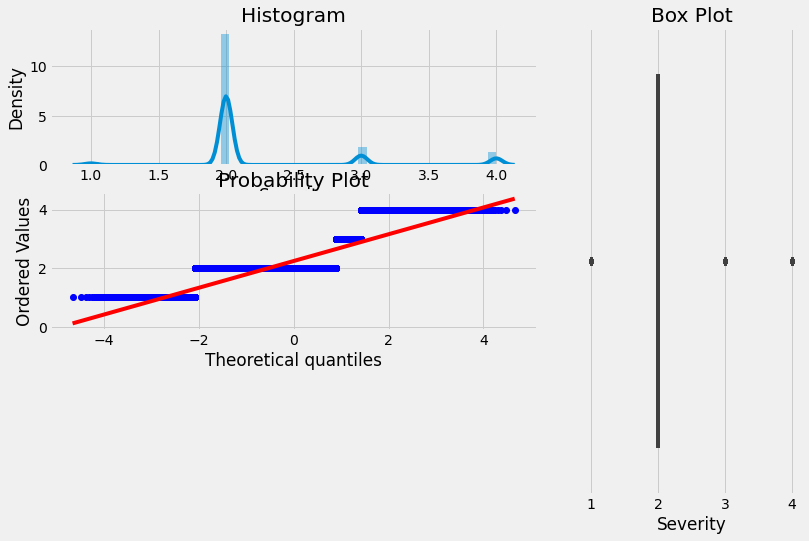

In [10]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(train, 'Severity')

These **three** charts above can tell us a lot about our target variable.
* Our target variable, **Severity** is not normally distributed.
* Our target variable is right-skewed. 
* There are multiple outliers in the variable.


**P.S.** 
* If you want to find out more about how to customize charts, try [this](https://matplotlib.org/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py) link. 
* If you are learning about Q-Q-plots for the first time. checkout [this](https://www.youtube.com/watch?v=smJBsZ4YQZw) video. 
* You can also check out [this](https://www.youtube.com/watch?v=9IcaQwQkE9I) one if you have some extra time. 

Let's find out how the `Severity` is distributed.

In [11]:
#skewness and kurtosis
print("Skewness: " + str(train['Severity'].skew()))
print("Kurtosis: " + str(train['Severity'].kurt()))

Skewness: 1.8136105304306374
Kurtosis: 2.79122020392118


It looks like there are quite a bit Skewness and Kurtosis in the target variable. Let's talk about those a bit. 

<b>Skewness</b> 
* is the degree of distortion from the symmetrical bell curve or the normal curve. 
* So, a symmetrical distribution will have a skewness of "0". 
* There are two types of Skewness: <b>Positive and Negative.</b> 
* <b>Positive Skewness</b>(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter. 
* In <b>positive Skewness </b> the mean and median will be greater than the mode similar to this dataset. Which means more more sever case by car accident than the average case.
* Skewness differentiates in extreme values in one versus the other tail. 

Here is a picture to make more sense.  
![image](https://cdn-images-1.medium.com/max/1600/1*nj-Ch3AUFmkd0JUSOW_bTQ.jpeg)


<b>Kurtosis</b>
According to Wikipedia, 

*In probability theory and statistics, **Kurtosis** is the measure of the "tailedness" of the probability. distribution of a real-valued random variable.* So, In other words, **it is the measure of the extreme values(outliers) present in the distribution.** 

* There are three types of Kurtosis: <b>Mesokurtic, Leptokurtic, and Platykurtic</b>. 
* Mesokurtic is similar to the normal curve with the standard value of 3. This means that the extreme values of this distribution are similar to that of a normal distribution. 
* Leptokurtic Example of leptokurtic distributions are the T-distributions with small degrees of freedom.
* Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions. 

![image](https://i2.wp.com/mvpprograms.com/help/images/KurtosisPict.jpg?resize=375%2C234)


You can read more about this from [this](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa) article. 

We can fix this by using different types of transformation(more on this later). However, before doing that, I want to find out the relationships among the target variable and other predictor variables. Let's find out.

In [12]:
## Getting the correlation of all the features with target variable. 
(train.corr()**2)["Severity"].sort_values(ascending = False)[1:]

Weather_Timestamp_Year     5.397496e-02
Start_Time_Year            5.397496e-02
End_Time_Year              5.393419e-02
Start_Lng                  3.396511e-02
End_Lng                    3.396466e-02
Distance(mi)               2.444140e-02
Start_Time_Month           1.506702e-02
Weather_Timestamp_Month    1.506671e-02
End_Time_Month             1.499724e-02
End_Lat                    5.683214e-03
Start_Lat                  5.680420e-03
Wind_Speed(mph)            3.603532e-03
Pressure(in)               3.125942e-03
Crossing                   3.034795e-03
Humidity(%)                2.437293e-03
Traffic_Signal             2.022418e-03
Junction                   4.500038e-04
Temperature(F)             3.263240e-04
Start_Time_Hour            2.244022e-04
Weather_Time_Hour          1.877970e-04
Station                    1.217496e-04
Give_Way                   4.180763e-05
Visibility(mi)             2.983816e-05
Railway                    1.913345e-05
Bump                       1.229787e-05


In [13]:
test.ID.value_counts()

A-3564816    1
A-3072155    1
A-3952666    1
A-3457811    1
A-3737132    1
            ..
A-3893102    1
A-3182914    1
A-3054019    1
A-4041459    1
A-4103092    1
Name: ID, Length: 151607, dtype: int64

These are the predictor variables sorted in a descending order starting with the most correlated one **Start_Lng**. Let's put this one in a scatter plot and see how it looks.

Severity

In [14]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12,8))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x)

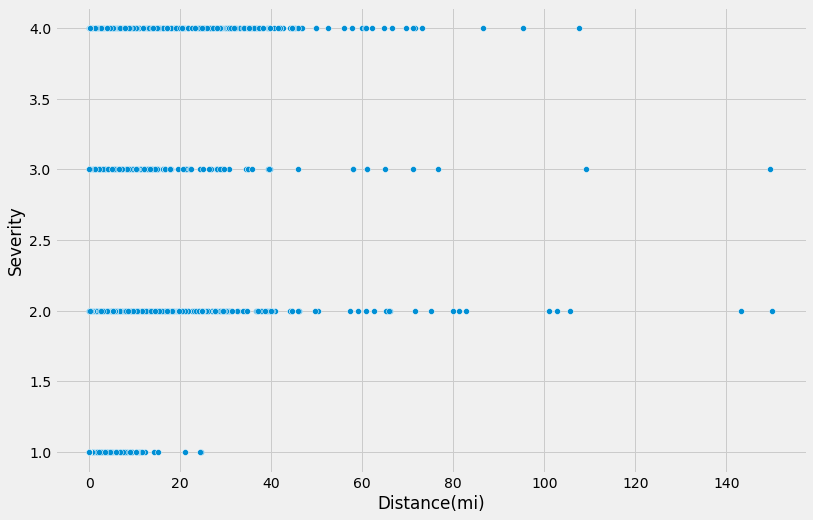

In [15]:
customized_scatterplot(train['Severity'], train['Distance(mi)'])

Okay, I think we have seen enough. Let's discuss what we have found so far. 

# Observations
* Our target variable shows an unequal level of variance across most predictor(independent) variables. This is called **Heteroscedasticity(more explanation below)** and is a red flag for the multiple linear regression model.
* There are many outliers in the scatter plots above that took my attention. 

* The two on the top-right edge of **Severity vs. Distance(mi)** seem to follow a trend, which can be explained by saying that "As the prices increased, so did the area.
* However, The two on the bottom right of the same chart do not follow any trends. We will get rid of these two below.

<a id="3.3"></a>
## 3.3 Feature selection

Here is the process of feature selection, in order to select the best features from which our models can learn.

From the observations made with the correlation matrix, we are going to drop the following features:
    - End_Lat and End_Lng
- Wind Chill

Moreover, we are going to drop the following features:
- ID, Source: since they don't carry any information for the severity
- TMC: because it could already contains information about the accident severity
- Start_Time: because it was decomposed by the time features added before (day, month, weekday)
- End_Time: beause we cannot know in advance when the traffic flow will become regular again
- Description: most description only report the name of the road of the accident, and so we decided to omit this feature for semplicity
    - Number, Street, County, State, Zipcode, Country: because we just focus on the City where the accident happened
- Timezone, Airport_Code, Weather_Timestamp: because they are not useful for our task
    - Turning_Loop: since it's always False
- Sunrise_Sunset, Nautical_Twilight, Astronomical_Twilight: because they are redundant

### Removing multicollinary columns

In [16]:
# select non-numeric columns
categorical = train.select_dtypes(exclude=[np.number])
categorical = categorical.columns.tolist()

# select non-numeric columns
numeric = train.select_dtypes(include=[np.number])
numeric = numeric.columns.tolist()

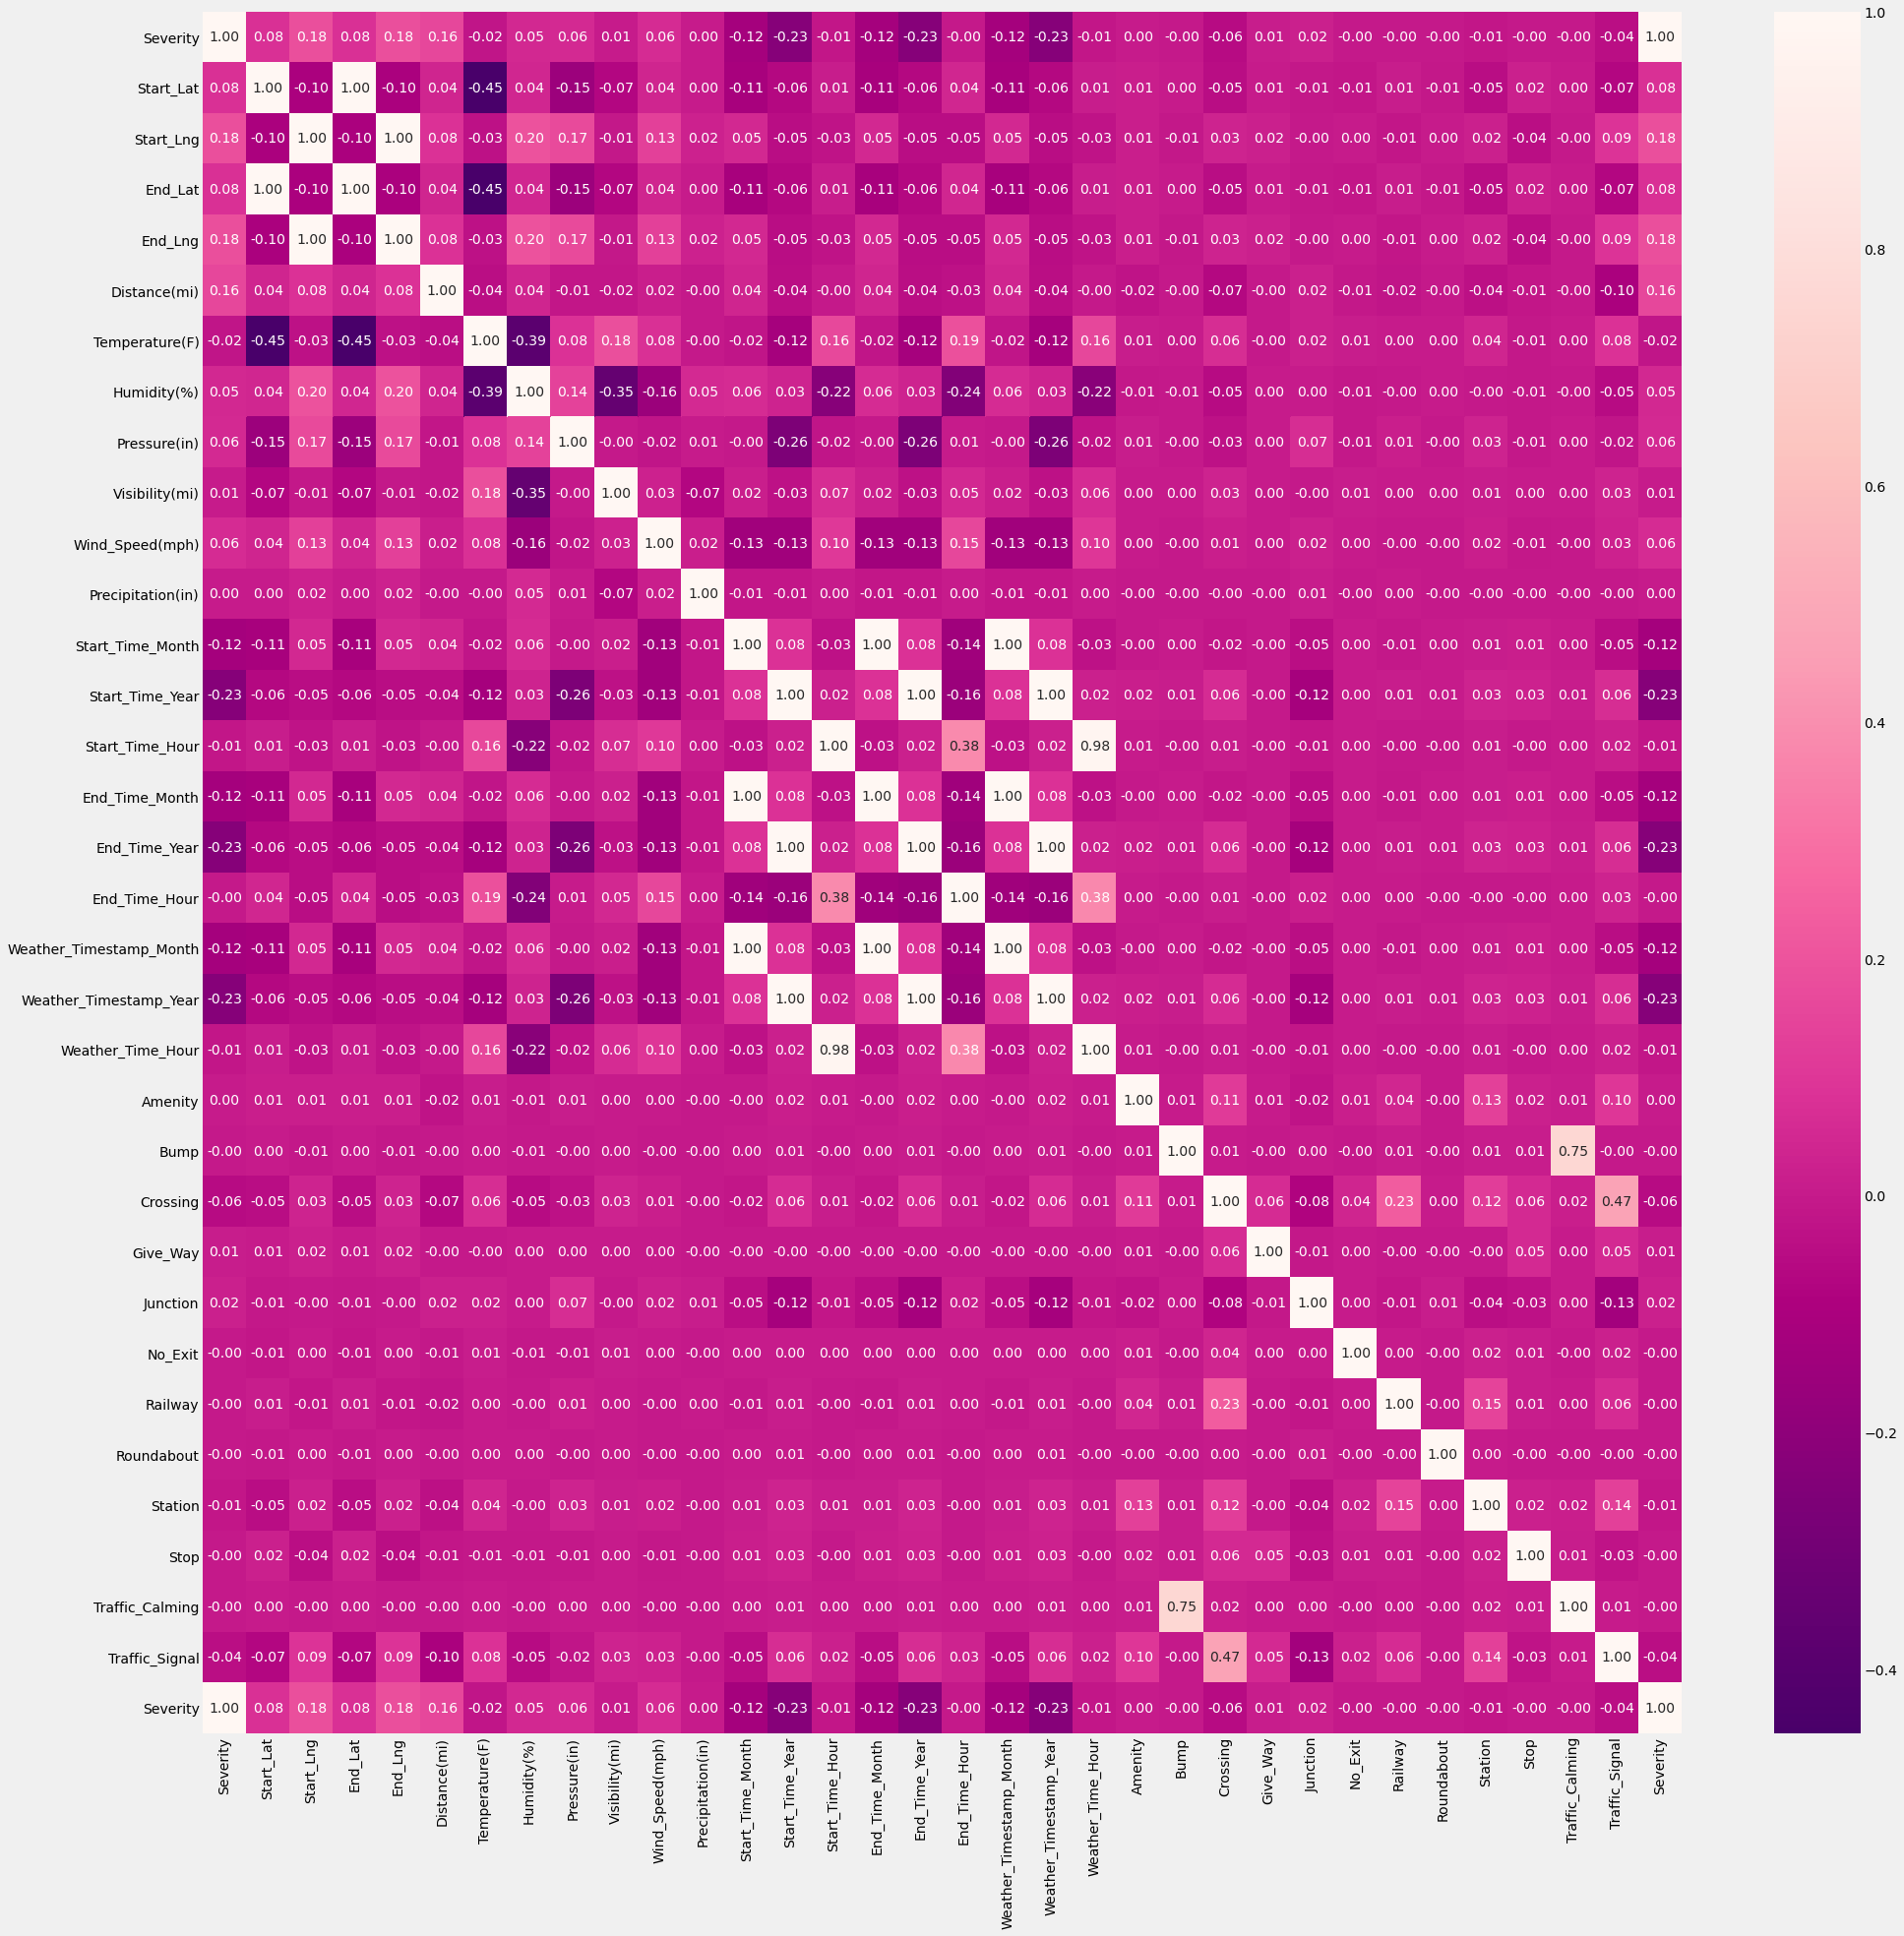

In [17]:
fig, ax = plt.subplots(figsize=(30,30))
g = sns.heatmap(train[[*numeric,*categorical,'Severity']].corr(),annot=True, fmt = ".2f", cmap = "RdPu_r")

**---------> OBSERVATIONS**

From the matrix we can see that the start and end GPS coordinates of the accidents are highly correlated.

In fact, from the medium distance shown before, the end of the accident is usually close to the start, so we can consider just one of them for the machine learning models.

Moreover, the wind chill (temperature) is directly proportional to the temperature, so we can also drop one of them.

We can also see that the presence of a traffic signal is slightly correlated to the severity of an accident meaning that maybe traffic lights can help the traffic flow when an accident occurs.

From the matrix we can also note that we couldn't compute the covariance with Turning_Loop, and that's because it's always False.

In [18]:
## Deleting those two values with outliers.
# train = train[train['Distance(mi)'] < 140]
# train.reset_index(drop = True, inplace = True)

## save a copy of this dataset so that any changes later on can be compared side by side.
previous_train = train.copy()

As we look through these scatter plots, I realized that it is time to explain the assumptions of Multiple Linear Regression. Before building a multiple linear regression model, we need to check that these assumptions below are valid.
## Assumptions of Regression

* **Linearity ( Correct functional form )** 
* **Homoscedasticity ( Constant Error Variance )( vs Heteroscedasticity ). **
* **Independence of Errors ( vs Autocorrelation ) **
* **Multivariate Normality ( Normality of Errors ) **
* **No or little Multicollinearity. ** 

Since we fit a linear model, we assume that the relationship is **linear**, and the errors, or residuals, are pure random fluctuations around the true line. We expect that the variability in the response(dependent) variable doesn't increase as the value of the predictor(independent) increases, which is the assumptions of equal variance, also known as **Homoscedasticity**. We also assume that the observations are independent of one another(**No Multicollinearity**), and a correlation between sequential observations or auto-correlation is not there.

Now, these assumptions are prone to happen altogether. In other words, if we see one of these assumptions in the dataset, it's more likely that we may come across with others mentioned above. Therefore, we can find and fix various assumptions with a few unique techniques.

So, **How do we check regression assumptions? We fit a regression line and look for the variability of the response data along the regression line.** Let's apply this to each one of them.

**Linearity(Correct functional form):** 
Linear regression needs the relationship between each independent variable and the dependent variable to be linear. The linearity assumption can be tested with scatter plots. The following two examples depict two cases, where no or little linearity is present. 

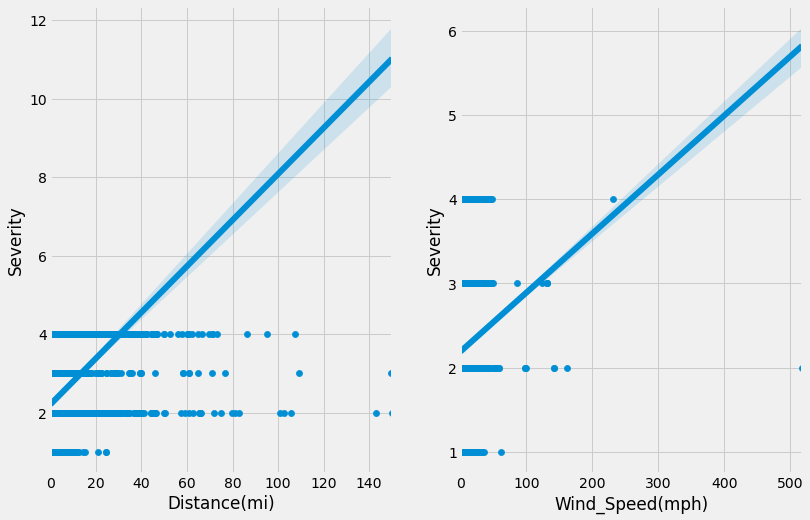

In [19]:
## Plot sizing. 
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
## Scatter plotting for Severity and Distance(mi).
sns.scatterplot( x = train['Distance(mi)'], y = train.Severity,  ax=ax1)
## Putting a regression line. 
sns.regplot(x=train['Distance(mi)'], y=train.Severity, ax=ax1)

## Scatter plotting for Severity and ['Wind_Speed(mph)'].
sns.scatterplot(x = train['Wind_Speed(mph)'],y = train.Severity, ax=ax2)
## regression line for MasVnrArea and Severity.
sns.regplot(x=train['Wind_Speed(mph)'], y=train.Severity, ax=ax2);

Severity

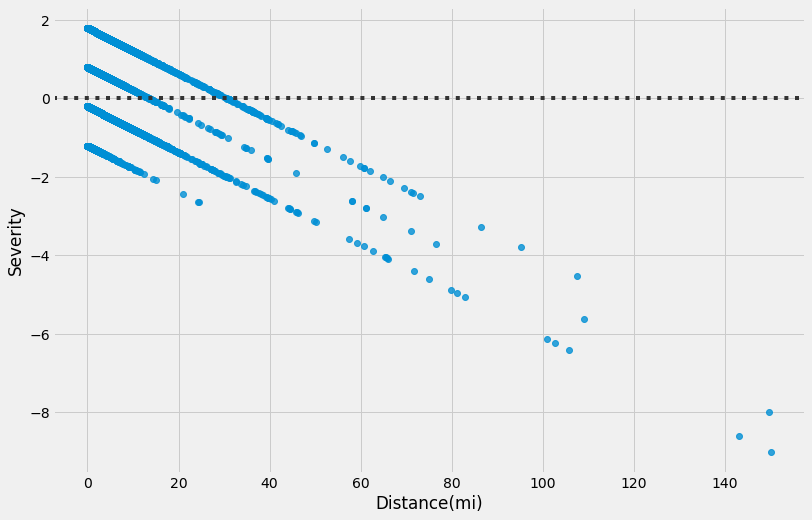

In [20]:
plt.subplots(figsize = (12,8))
sns.residplot(train['Distance(mi)'], train.Severity);

Distance(mi)

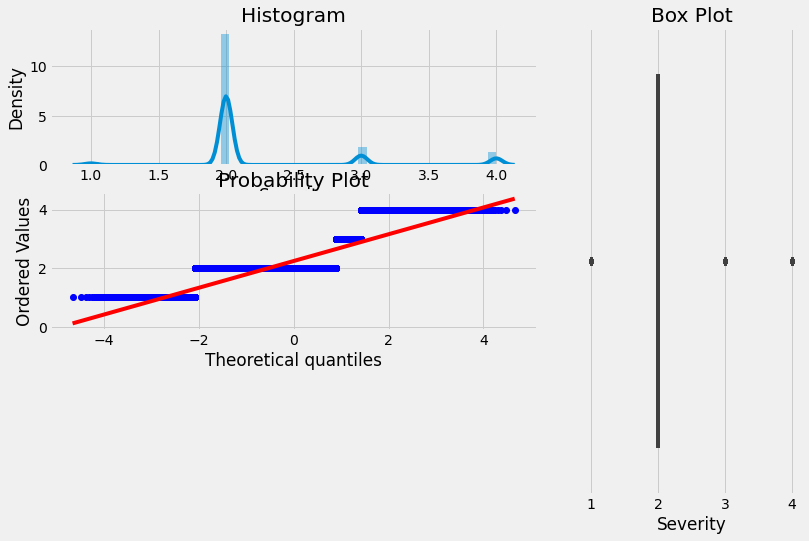

In [21]:
plotting_3_chart(train, 'Severity')

Now, let's make sure that the target variable follows a normal distribution. If you want to learn more about the probability plot(Q-Q plot), try [this](https://www.youtube.com/watch?v=smJBsZ4YQZw) video. You can also check out [this](https://www.youtube.com/watch?v=9IcaQwQkE9I) one if you have some extra time.

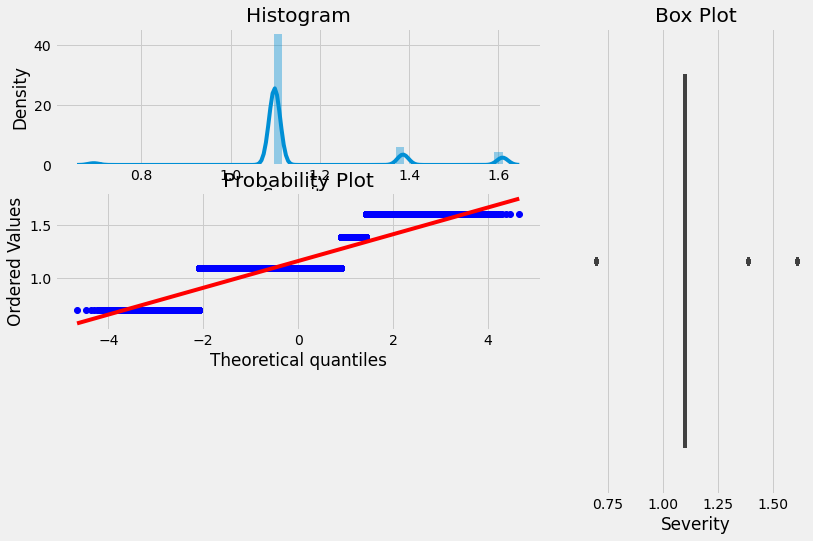

In [22]:
## transforming target variable using numpy.log1p,
train["Severity"] = np.log1p(train["Severity"])

## Plotting the newly transformed response variable
plotting_3_chart(train, 'Severity')

As you can see, the log transformation removes the normality of errors, which solves most of the other errors we talked about above. Let's make a comparison of the pre-transformed and post-transformed state of residual plots. 

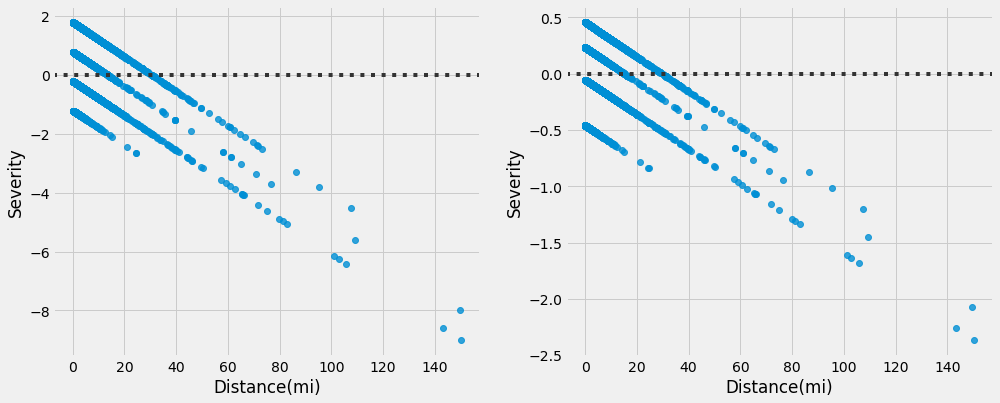

In [23]:
## Customizing grid for two plots. 
fig, (ax1, ax2) = plt.subplots(figsize = (15,6), 
                               ncols=2, 
                               sharey = False, 
                               sharex=False
                              )
## doing the first scatter plot. 
sns.residplot(x = previous_train['Distance(mi)'], y = previous_train.Severity, ax = ax1)
## doing the scatter plot for Distance(mi) and Severity.
sns.residplot(x = train['Distance(mi)'], y = train.Severity, ax = ax2);

Here, we see that the pre-transformed chart on the left has heteroscedasticity, and the post-transformed chart on the right has Homoscedasticity(almost an equal amount of variance across the zero lines). It looks like a blob of data points and doesn't seem to give away any relationships. That's the sort of relationship we would like to see to avoid some of these assumptions. 

**No or Little multicollinearity:** 
Multicollinearity is when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:
* The effect of predictor variables estimated by our regression will depend on what other variables are included in our model. 
* Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects. 
* With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate. 
* We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant. The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

Heatmap is an excellent way to identify whether there is multicollinearity or not. The best way to solve multicollinearity is to use regularization methods like Ridge or Lasso.

### 16. Data Correlation

###### 4. Quantify the association of features and accidents
We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).

To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:

0.2 = weak
0.5 = medium
0.8 = strong
0.9 = very strong

In [24]:
# For example max HP is 255 or min defense is 5
train.describe() #ignore null entries

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Precipitation(in),Start_Time_Month,Start_Time_Year,Start_Time_Hour,End_Time_Month,End_Time_Year,End_Time_Hour,Weather_Timestamp_Month,Weather_Timestamp_Year,Weather_Time_Hour
count,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,...,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000,438700.000000
mean,1.161569,36.924992,-98.719154,36.925070,-98.719007,0.586301,59.671724,64.663488,29.568323,9.161630,...,0.005713,7.681851,2018.894274,12.546825,7.685297,2018.894438,12.717370,7.681824,2018.894274,12.268894
std,0.167576,5.156410,18.477496,5.156403,18.477345,1.630518,18.140203,22.951424,0.999707,2.861522,...,0.104330,3.649626,1.365008,6.152619,3.651002,1.364907,7.029786,3.649635,1.365008,6.085492
min,0.693147,24.570222,-124.497567,24.570110,-124.497478,0.000000,-89.000000,1.000000,0.300000,0.060000,...,0.000000,1.000000,2016.000000,0.000000,1.000000,2016.000000,0.000000,1.000000,2016.000000,0.000000
25%,1.098612,33.858560,-118.214156,33.858335,-118.214103,0.000000,48.000000,49.000000,29.470000,10.000000,...,0.000000,4.000000,2018.000000,8.000000,4.000000,2018.000000,7.000000,4.000000,2018.000000,7.000000
50%,1.098612,37.354780,-94.525898,37.354760,-94.525877,0.178000,61.000000,68.000000,29.880000,10.000000,...,0.000000,9.000000,2020.000000,14.000000,9.000000,2020.000000,14.000000,9.000000,2020.000000,13.000000
75%,1.098612,40.732080,-80.940801,40.732111,-80.940395,0.593000,73.000000,84.000000,30.040000,10.000000,...,0.000000,11.000000,2020.000000,17.000000,11.000000,2020.000000,18.000000,11.000000,2020.000000,17.000000
max,1.609438,49.000560,-67.403551,49.000760,-67.403550,150.138000,168.800000,100.000000,38.940000,120.000000,...,24.000000,12.000000,2020.000000,23.000000,12.000000,2021.000000,23.000000,12.000000,2020.000000,23.000000


In [25]:
# compare severity level rate across numerical columns
pd.pivot_table(train, index = 'Severity', values = ['Start_Lat', 'Start_Lng','End_Lat','End_Lng','Distance(mi)','Temperature(F)',
                                                    'Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)'])

,Distance(mi),End_Lat,End_Lng,Humidity(%),Precipitation(in),Pressure(in),Start_Lat,Start_Lng,Temperature(F),Visibility(mi),Wind_Speed(mph)
Severity,,,,,,,,,,,
0.693147,0.205729,35.617272,-101.051957,49.897268,0.005023,29.022293,35.617058,-101.051787,71.279330,9.535951,8.377550
1.098612,0.499811,36.785512,-100.343555,64.764718,0.005436,29.564639,36.785488,-100.343740,59.254866,9.127562,7.366809
1.386294,0.611694,37.447182,-92.896021,64.313221,0.008278,29.585440,37.446907,-92.896050,61.721307,9.382665,8.777140
1.609438,1.538834,37.948725,-89.538847,67.654801,0.005117,29.713476,37.948390,-89.538839,58.311019,9.112706,8.109144


**-----------> OBSERVATION**
+ Diverse range of values for different features
+ Distanced algorithm might be benefit from scaling

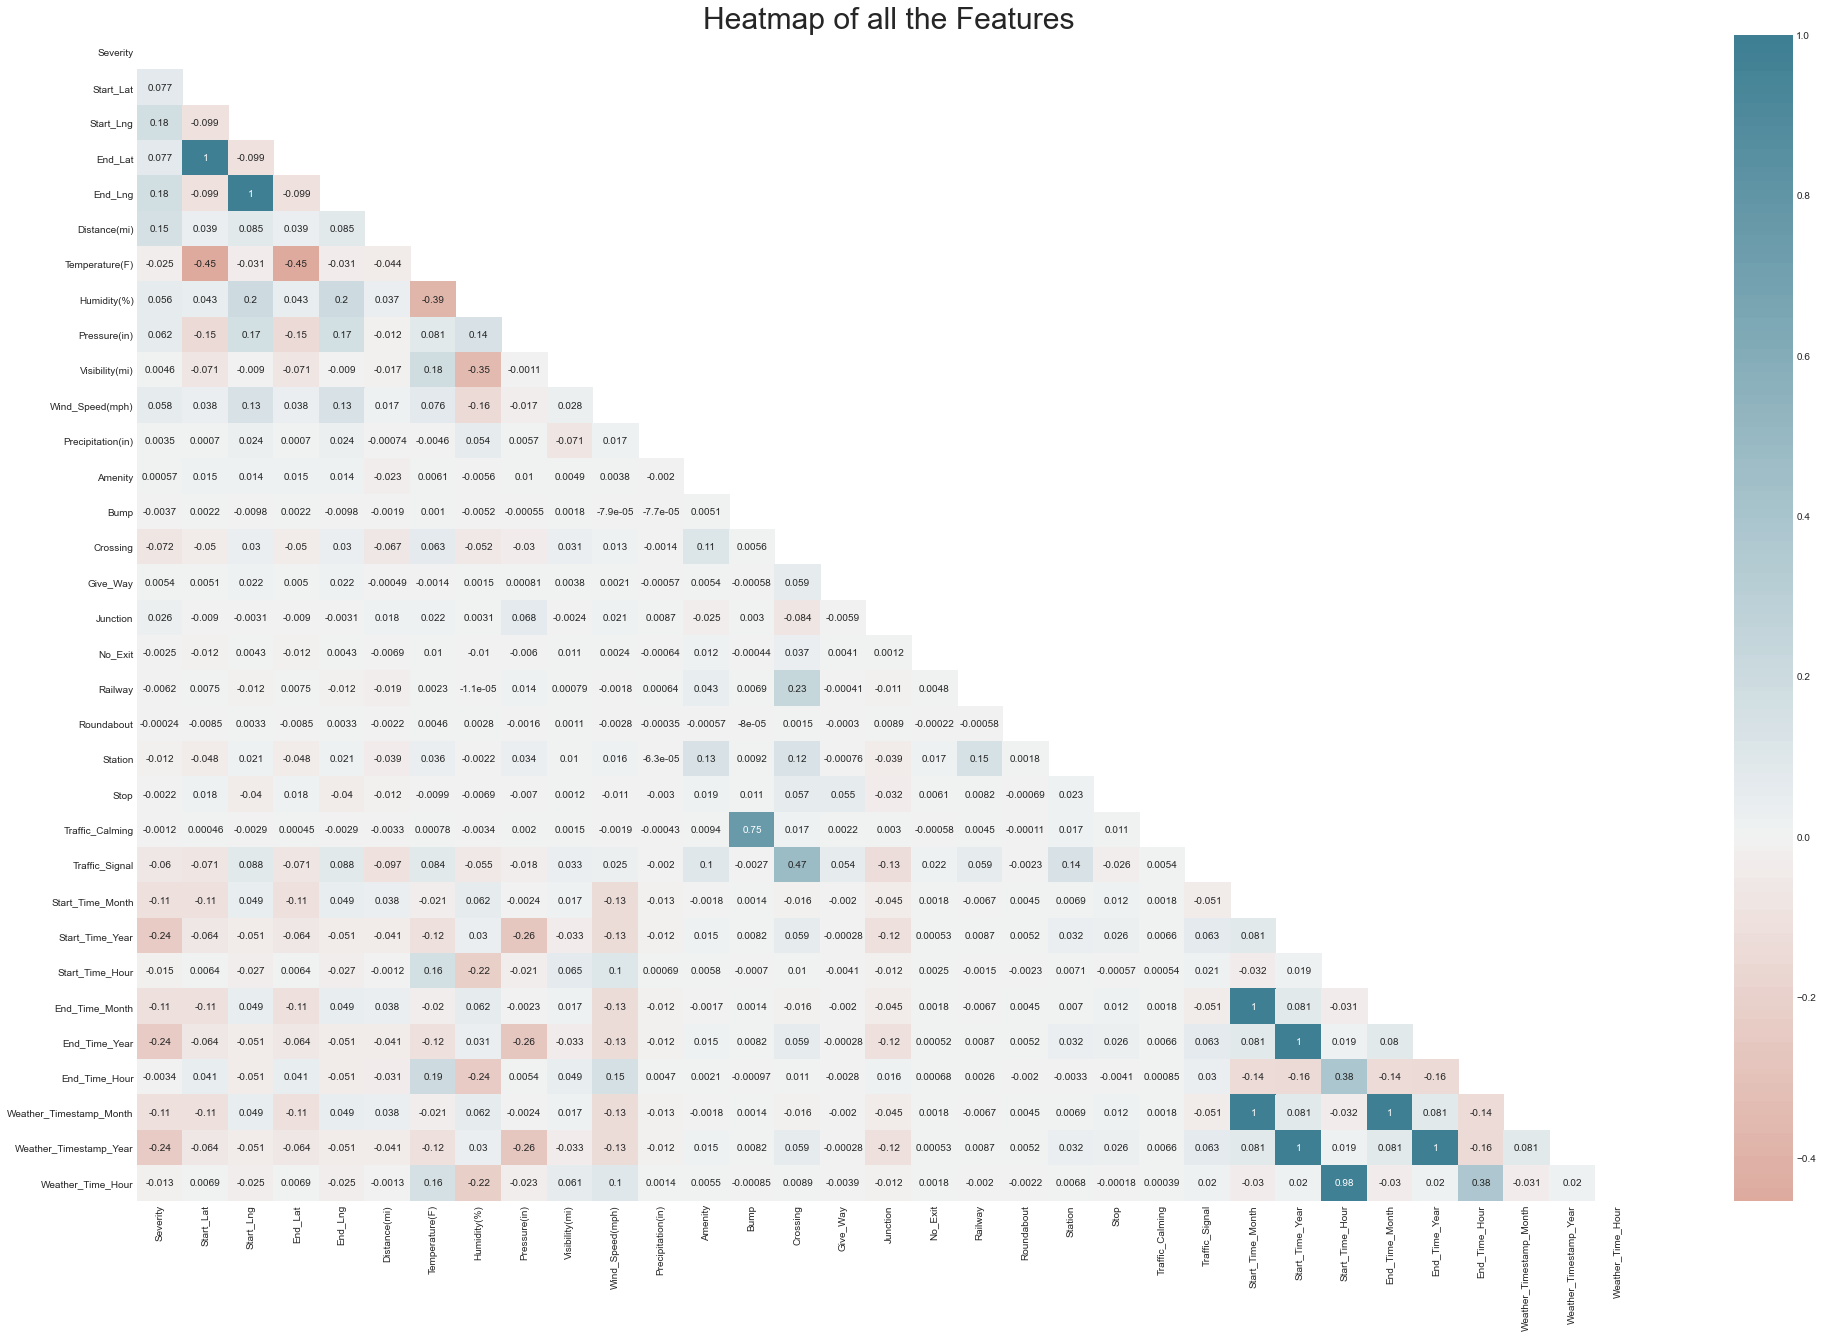

In [26]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );

## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

# Missing Values

In [4]:
print("Total missing values:", train.isna().sum().sum())
print("Total missing values:", test.isna().sum().sum())
print("Total missing values:", VALIDATION.isna().sum().sum())

Total missing values: 0
Total missing values: 0
Total missing values: 0


In [6]:
# select non-numeric columns
categorical = train.select_dtypes(exclude=[np.number])
categorical = categorical.columns.tolist()
print(f'List of non numeric in train dataset is {categorical}\n\n')


# select non-numeric columns
numeric = train.select_dtypes(include=[np.number])
numeric = numeric.columns.tolist()
print(f'List of numeric in test dataset is {numeric}\n\n')

List of non numeric in train dataset is ['Side', 'City', 'County', 'State', 'Zipcode', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


List of numeric in test dataset is ['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Start_Time_Month', 'Start_Time_Year', 'Start_Time_Hour', 'End_Time_Month', 'End_Time_Year', 'End_Time_Hour', 'Weather_Timestamp_Month', 'Weather_Timestamp_Year', 'Weather_Time_Hour']




In [41]:
"""
Weather_Timestamp_Year     5.397496e-02
Start_Time_Year            5.397496e-02
End_Time_Year              5.393419e-02
Start_Lng                  3.396511e-02
End_Lng                    3.396466e-02
Distance(mi)               2.444140e-02
Start_Time_Month           1.506702e-02
Weather_Timestamp_Month    1.506671e-02
End_Time_Month             1.499724e-02
End_Lat                    5.683214e-03
Start_Lat                  5.680420e-03
Wind_Speed(mph)            3.603532e-03
Pressure(in)               3.125942e-03
Crossing                   3.034795e-03
Humidity(%)                2.437293e-03
Traffic_Signal             2.022418e-03
Junction                   4.500038e-04
Temperature(F)             3.263240e-04
Start_Time_Hour            2.244022e-04
Weather_Time_Hour          1.877970e-04
Station                    1.217496e-04
Give_Way                   4.180763e-05
Visibility(mi)             2.983816e-05
Railway                    1.913345e-05
Bump                       1.229787e-05
Amenity                    9.943897e-06
Precipitation(in)          9.772687e-06
End_Time_Hour              7.921444e-06
No_Exit                    1.122199e-06
Traffic_Calming            1.111709e-06
Stop                       1.101762e-07
Roundabout                 5.011702e-08
"""

'\nWeather_Timestamp_Year     5.397496e-02\nStart_Time_Year            5.397496e-02\nEnd_Time_Year              5.393419e-02\nStart_Lng                  3.396511e-02\nEnd_Lng                    3.396466e-02\nDistance(mi)               2.444140e-02\nStart_Time_Month           1.506702e-02\nWeather_Timestamp_Month    1.506671e-02\nEnd_Time_Month             1.499724e-02\nEnd_Lat                    5.683214e-03\nStart_Lat                  5.680420e-03\nWind_Speed(mph)            3.603532e-03\nPressure(in)               3.125942e-03\nCrossing                   3.034795e-03\nHumidity(%)                2.437293e-03\nTraffic_Signal             2.022418e-03\nJunction                   4.500038e-04\nTemperature(F)             3.263240e-04\nStart_Time_Hour            2.244022e-04\nWeather_Time_Hour          1.877970e-04\nStation                    1.217496e-04\nGive_Way                   4.180763e-05\nVisibility(mi)             2.983816e-05\nRailway                    1.913345e-05\nBump         

In [7]:
unneeded_columns = ['Side', 'City', 'County', 'State', 'Zipcode', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump',  
                    'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Sunrise_Sunset', 
                    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

data = data.drop(unneeded_columns, axis=1)
test = test.drop(unneeded_columns, axis=1)
validation = VALIDATION.drop(unneeded_columns, axis=1)

# Encoding

In [8]:
data = data.replace([True, False], [1,0])
test = test.replace([True, False], [1,0])
validation = validation.replace([True, False], [1,0])


def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

"""
List of non numeric in train dataset is ['Timezone', 'Crossing', 'Traffic_Signal']


List of numeric in test dataset is ['Severity', 'Weather_Timestamp_Year', 'Start_Lng', 'Distance(mi)', 'Humidity(%)', 'Pressure_bc', 'Wind_Speed_bc']
"""

data = onehot_encode(
    data,
    columns=['Timezone', 'Crossing', 'Traffic_Signal'],
    prefixes=['Timezone', 'Crossing', 'Traffic_Signal']
)

test = onehot_encode(
    test,
    columns=['Timezone', 'Crossing', 'Traffic_Signal'],
    prefixes=['Timezone', 'Crossing', 'Traffic_Signal']
)

validation = onehot_encode(
    validation,
    columns=['Timezone', 'Crossing', 'Traffic_Signal'],
    prefixes=['Timezone', 'Crossing', 'Traffic_Signal']
)

In [9]:
data.head(3)

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Weather_Timestamp_Year,Weather_Time_Hour,Timezone_us/central,Timezone_us/eastern,Timezone_us/mountain,Timezone_us/pacific,Crossing_0,Crossing_1,Traffic_Signal_0,Traffic_Signal_1
0,2,39.10148,-84.52341,39.09841,-84.52241,0.219,36.0,97,29.70,10.0,...,2016,5,0,1,0,0,1,0,1,0
1,2,41.06213,-81.53784,41.06217,-81.53547,0.123,39.0,55,29.65,10.0,...,2016,6,0,1,0,0,1,0,1,0
2,2,39.06324,-84.03243,39.06731,-84.05851,1.427,35.6,100,29.66,10.0,...,2016,8,0,1,0,0,1,0,0,1


# Splitting/Scaling

# 📈 Training a Linear Regression Model

> Let's now begin to train out regression model! We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case the Price column. We will toss out the Address column because it only has text info that the linear regression model can't use.

## X and y arrays

## 🧱 Train Test Split

Now let's split the data into a training set and a testing set. We will train out model on the training set and then use the test set to evaluate the model.

In [12]:
X = train.drop(['Severity'], axis = 1)
y = train['Severity']

X_train = X
y_train = y

accident_ID = test.ID.to_list()
TEST = test.drop(['ID'], axis = 1)

X_test = validation.drop(['Severity'], axis = 1)
y_test = validation['Severity']

# 📦 Preparing Data For Multiple Linear Regression
> Linear regression is been studied at great length, and there is a lot of literature on how your data must be structured to make best use of the model.

> As such, there is a lot of sophistication when talking about these requirements and expectations which can be intimidating. In practice, you can uses these rules more as rules of thumb when using Ordinary Least Squares Regression, the most common implementation of linear regression.

> Try different preparations of your data using these heuristics and see what works best for your problem.
- **Linear Assumption.** Linear regression assumes that the relationship between your input and output is linear. It does not support anything else. This may be obvious, but it is good to remember when you have a lot of attributes. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).
- **Remove Noise.** Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.
- **Remove Collinearity.** Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
- **Gaussian Distributions.** Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
- **Rescale Inputs:** Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

In [10]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
TEST = pipeline.fit_transform(TEST)

CPU times: user 71.7 ms, sys: 11.8 ms, total: 83.5 ms
Wall time: 82.9 ms


## ✔️ Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

> - **Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:
$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

> - **Mean Squared Error** (MSE) is the mean of the squared errors:
$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

> - **Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

> - **Residuals** (R2):

> 📌 Comparing these metrics:
- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.
- **R2** is independent of each other, independent of x, normally distributed, common variance, have 0 mean

> All of these are **loss functions**, because we want to minimize them.

In [9]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# ✔️ Linear Regression

In [11]:
%%time

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

CPU times: user 209 ms, sys: 23.7 ms, total: 233 ms
Wall time: 65.7 ms


LinearRegression(normalize=True)

## ✔️ Model Evaluation

Let's evaluate the model by checking out it's coefficients and how we can interpret them.

In [12]:
# print the intercept
print(lin_reg.intercept_)

2.2436152268064675


In [13]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Distance(mi),0.087860
Temperature(F),-0.014064
Humidity(%),0.034981
Pressure(in),-0.004078
Visibility(mi),0.014190
Wind_Speed(mph),0.023197
Precipitation(in),-0.000998
End_Time_Year,-0.138812


> Interpreting the coefficients:
- Holding all other features fixed, a 1 unit increase in **Distance(mi)** is associated with an **increase of \0.087860**.
- Holding all other features fixed, a 1 unit increase in **Temperature(F)** is associated with an **decrease of \-0.014064**.

## ✔️ Predictions from our Model

Let's grab predictions off our test set and see how well it did!

In [14]:
%%time

pred = lin_reg.predict(X_test)

CPU times: user 13.5 ms, sys: 3.35 ms, total: 16.8 ms
Wall time: 1.61 ms


In [15]:
# import hvplot.pandas

# pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

**Residual Histogram**

In [16]:
# pd.DataFrame({'Error Values': (y_test - pred)}).hvplot.kde()

In [18]:
%%time

test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.396735991419281
MSE: 0.34239345438028196
RMSE: 0.5851439603894771
R2 Square 0.07947902370064608
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.3997139491539972
MSE: 0.34458531889164357
RMSE: 0.5870139000838426
R2 Square 0.08036438496918397
__________________________________
CPU times: user 209 ms, sys: 13 ms, total: 222 ms
Wall time: 22.5 ms


In [22]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238


In [23]:
%%time

y_predict_model_lin_reg = lin_reg.predict(TEST)

output = pd.DataFrame({"ID": accident_ID, "Severity": y_predict_model_lin_reg})

output.to_csv('submission_lin_reg.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
CPU times: user 1.99 s, sys: 39.5 ms, total: 2.03 s
Wall time: 245 ms


# Regularization Techniques

* Linear regression works by selecting coefficients for each independent variable that minimizes a loss function. However, if the coefficients are too large, it can lead to model over-fitting on the training dataset. Such a model will not generalize well on the unseen data. To overcome this shortcoming, we do regularization which penalizes large coefficients. The following are the regularization algorithms.

#### Pros of Regularization

--> We can use a regularized model to reduce the dimensionality of the training dataset. Dimensionality reduction is important because of three main reasons:

--> Prevents Overfitting: A high-dimensional dataset having too many features can sometimes lead to overfitting (model captures both real and random effects).

--> Simplicity: An over-complex model having too many features can be hard to interpret especially when features are correlated with each other.

--> Computational Efficiency: A model trained on a lower dimensional dataset is computationally efficient (execution of algorithm requires less computational time).


#### Cons of Regularization

--> Regularization leads to dimensionality reduction, which means the machine learning model is built using a lower dimensional dataset. This generally leads to a high bias errror.

--> If regularization is performed before training the model, a perfect balance between bias-variance tradeoff must be used.


# ✔️ Ridge Regression

> Source: [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

> Ridge regression addresses some of the problems of **Ordinary Least Squares** by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares,

$$\min_{w}\big|\big|Xw-y\big|\big|^2_2+\alpha\big|\big|w\big|\big|^2_2$$

> $\alpha>=0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

> Ridge regression is an L2 penalized model. Add the squared sum of the weights to the least-squares cost function.
***

#### Pros

--> Avoids overfitting a model.

--> The ridge estimator is preferably good at improving the least-squares estimate when there is multicollinearity.


#### Cons

--> They include all the predictors in the final model.

--> They are unable to perform feature selection.

--> They shrink the coefficients towards zero.

--> They trade the variance for bias.

In [24]:
%%time

from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.3967432596435439
MSE: 0.34239315777208296
RMSE: 0.5851437069405113
R2 Square 0.07947982112847496
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.3997210355530711
MSE: 0.34458532046786255
RMSE: 0.5870139014264164
R2 Square 0.08036438076254171
__________________________________
CPU times: user 246 ms, sys: 6.01 ms, total: 252 ms
Wall time: 35.6 ms


In [25]:
results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238


In [26]:
%%time

y_predict_Ridge = model.predict(TEST)

output = pd.DataFrame({"ID": accident_ID, "Severity": y_predict_Ridge})

output.to_csv('submission_Ridge.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
CPU times: user 1.97 s, sys: 63.9 ms, total: 2.04 s
Wall time: 266 ms


# ✔️ LASSO Regression

> A linear model that estimates sparse coefficients.

> Mathematically, it consists of a linear model trained with $\ell_1$ prior as regularizer. The objective function to minimize is:

$$\min_{w}\frac{1}{2n_{samples}} \big|\big|Xw - y\big|\big|_2^2 + \alpha \big|\big|w\big|\big|_1$$

> The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha \big|\big|w\big|\big|_1$ added, where $\alpha$ is a constant and $\big|\big|w\big|\big|_1$ is the $\ell_1-norm$ of the parameter vector.
***

#### Pros

--> Avoids overfitting a model.

--> The ridge estimator is preferably good at improving the least-squares estimate when there is multicollinearity.


#### Cons

--> They include all the predictors in the final model.

--> They are unable to perform feature selection.

--> They shrink the coefficients towards zero.

--> They trade the variance for bias.


In [27]:
%%time

from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.43189534125318396
MSE: 0.37195711259002145
RMSE: 0.6098828679263104
R2 Square -2.5410607653597594e-06
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.4338350159559747
MSE: 0.3746976664013788
RMSE: 0.6121255315712446
R2 Square 0.0
__________________________________
CPU times: user 239 ms, sys: 5.83 ms, total: 245 ms
Wall time: 34.6 ms


In [28]:
results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238
2,Lasso Regression,0.431895,0.371957,0.609883,-0.000003,-0.283739


In [29]:
%%time

y_predict_Lasso = model.predict(TEST)

output = pd.DataFrame({"ID": accident_ID, "Severity": y_predict_Lasso})

output.to_csv('submission_lasso.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
CPU times: user 2.01 s, sys: 30.9 ms, total: 2.04 s
Wall time: 255 ms


# ✔️ Elastic Net

> A linear regression model trained with L1 and L2 prior as regularizer. 

> This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. 

> Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

> A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

> The objective function to minimize is in this case

$$\min_{w}{\frac{1}{2n_{samples}} \big|\big|X w - y\big|\big|_2 ^ 2 + \alpha \rho \big|\big|w\big|\big|_1 +
\frac{\alpha(1-\rho)}{2} \big|\big|w\big|\big|_2 ^ 2}$$
***

#### Pros
--> Doesn’t have the problem of selecting more than n predictors when n<<p, whereas LASSO saturates when n<<p.

#### Cons
--> Computationally more expensive than LASSO or Ridge.

In [30]:
%%time 

from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.4219970856318469
MSE: 0.35936427959007833
RMSE: 0.5994699989074335
R2 Square 0.03385314975103282
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.42438154469890454
MSE: 0.36205831914287834
RMSE: 0.6017128211554731
R2 Square 0.03373212163259409
__________________________________
CPU times: user 290 ms, sys: 19.8 ms, total: 310 ms
Wall time: 48.7 ms


In [31]:
results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238
2,Lasso Regression,0.431895,0.371957,0.609883,-0.000003,-0.283739
3,Elastic Net Regression,0.421997,0.359364,0.599470,0.033853,-0.290481


In [32]:
%%time

y_predict_ElasticNet = model.predict(TEST)

output = pd.DataFrame({"ID": accident_ID, "Severity": y_predict_ElasticNet})

output.to_csv('submission_ElasticNet.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
CPU times: user 2 s, sys: 41.8 ms, total: 2.04 s
Wall time: 258 ms


# ✔️ Polynomial Regression
> Source: [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)

***

> One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

> For example, a simple linear regression can be extended by constructing polynomial features from the coefficients. In the standard linear regression case, you might have a model that looks like this for two-dimensional data:

$$\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2$$

> If we want to fit a paraboloid to the data instead of a plane, we can combine the features in second-order polynomials, so that the model looks like this:

$$\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1 x_2 + w_4 x_1^2 + w_5 x_2^2$$

> The (sometimes surprising) observation is that this is still a linear model: to see this, imagine creating a new variable

$$z = [x_1, x_2, x_1 x_2, x_1^2, x_2^2]$$

> With this re-labeling of the data, our problem can be written

$$\hat{y}(w, x) = w_0 + w_1 z_1 + w_2 z_2 + w_3 z_3 + w_4 z_4 + w_5 z_5$$

> We see that the resulting polynomial regression is in the same class of linear models we’d considered above (i.e. the model is linear in w) and can be solved by the same techniques. By considering linear fits within a higher-dimensional space built with these basis functions, the model has the flexibility to fit a much broader range of data.
***

In [33]:
%%time

from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.3832169133814977
MSE: 0.32963692619168977
RMSE: 0.5741401624966588
R2 Square 0.11377480719804622
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.3867504793758513
MSE: 0.33156552737604666
RMSE: 0.5758172690846001
R2 Square 0.11511184320835532
__________________________________
CPU times: user 2.34 s, sys: 114 ms, total: 2.45 s
Wall time: 741 ms


In [34]:
results_df_2 = pd.DataFrame(data=[["Polynomail Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238
2,Lasso Regression,0.431895,0.371957,0.609883,-0.000003,-0.283739
3,Elastic Net Regression,0.421997,0.359364,0.599470,0.033853,-0.290481
4,Polynomail Regression,0.383217,0.329637,0.574140,0.113775,0.000000


In [ ]:
%%time

y_predict_poly_reg = lin_reg.predict(TEST)

output = pd.DataFrame()
output['ID'] = accident_ID
output['Severity'] = y_predict_poly_reg

output.to_csv('submission_poly_reg.csv', index=False)
print("Submission was successfully saved!")

# ✔️ Stochastic Gradient Descent

> Gradient Descent is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Sescent is to tweak parameters iteratively in order to minimize a cost function. Gradient Descent measures the local gradient of the error function with regards to the parameters vector, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum.

In [49]:
%%time

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.3968088371332172
MSE: 0.34239107934588064
RMSE: 0.5851419309414432
R2 Square 0.07948540895409617
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.39978724693975304
MSE: 0.3445853692801283
RMSE: 0.5870139430031694
R2 Square 0.08036425049147233
__________________________________
CPU times: user 12.1 s, sys: 19.2 ms, total: 12.1 s
Wall time: 11.9 s


In [50]:
results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238
2,Lasso Regression,0.431895,0.371957,0.609883,-0.000003,-0.283739
3,Elastic Net Regression,0.421997,0.359364,0.599470,0.033853,-0.290481
4,Polynomail Regression,0.383217,0.329637,0.574140,0.113775,0.000000
5,Stochastic Gradient Descent,0.396709,0.342394,0.585145,0.079477,0.000000
6,Stochastic Gradient Descent,0.396740,0.342391,0.585142,0.079485,0.000000
7,Stochastic Gradient Descent,0.396809,0.342391,0.585142,0.079485,0.000000


In [51]:
y_test

,Severity
0,2
1,3
2,2
3,3
4,2
...,...
149717,2
149718,2
149719,2
149720,2


In [52]:
train_pred

array([2.58699034, 2.5158458 , 2.66204556, ..., 2.13671226, 2.11760091,
       2.06727744])

In [53]:
test_pred

array([2.57860874, 2.57055462, 2.75807996, ..., 2.14440367, 2.16700354,
       2.22798579])

In [54]:
X_train

array([[-0.22526654, -1.30493309,  1.40891255, ..., -0.1135649 ,
         0.13694393, -2.12061456],
       [-0.28414359, -1.13955437, -0.42104135, ..., -0.1135649 ,
        -0.05475594, -2.12061456],
       [ 0.515603  , -1.32698359,  1.53962355, ...,  0.09622459,
        -0.05475594, -2.12061456],
       ...,
       [-0.17252251,  0.23860159,  1.53962355, ..., -0.30428262,
        -0.05475594,  0.80999163],
       [-0.34976696, -0.53316575,  0.27608394, ..., -0.1135649 ,
        -0.05475594,  0.80999163],
       [-0.21913351, -1.19468061,  0.97320924, ..., -0.49500034,
        -0.05475594,  1.54264317]])

In [55]:
y_train

0         2
1         2
2         2
3         2
4         2
         ..
438695    2
438696    2
438697    2
438698    2
438699    2
Name: Severity, Length: 438700, dtype: int64

In [56]:
%%time

y_predict_poly_sgd_reg = sgd_reg.predict(TEST)

output = pd.DataFrame({"ID": accident_ID, "Severity": y_predict_poly_sgd_reg})

output.to_csv('submission_sgd_reg.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
CPU times: user 1.98 s, sys: 33.5 ms, total: 2.02 s
Wall time: 234 ms


In [57]:
y_predict_poly_sgd_reg

array([2.54639233, 2.54216616, 2.66515796, ..., 2.1326299 , 2.33486204,
       2.15035582])

# ✔️ Artficial Neural Network

In [59]:
%%time

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=10)

Defaulting to user installation because normal site-packages is not writeable
Epoch 1/10
438700/438700 [==============================] - 338s 769us/step - loss: 0.3924 - val_loss: 0.3324
Epoch 2/10
438700/438700 [==============================] - 337s 769us/step - loss: 0.3355 - val_loss: 0.3263
Epoch 3/10
438700/438700 [==============================] - 337s 768us/step - loss: 0.3306 - val_loss: 0.3243
Epoch 4/10
438700/438700 [==============================] - 338s 771us/step - loss: 0.3275 - val_loss: 0.3201
Epoch 5/10
438700/438700 [==============================] - 329s 749us/step - loss: 0.3251 - val_loss: 0.3188
Epoch 6/10
438700/438700 [==============================] - 335s 763us/step - loss: 0.3240 - val_loss: 0.3216
Epoch 7/10
438700/438700 [==============================] - 329s 750us/step - loss: 0.3228 - val_loss: 0.3177
Epoch 8/10
438700/438700 [==============================] - 327s 746us/step - loss: 0.3222 - val_loss: 0.3213
Epoch 9/10
438700/438700 [================

**---->OBSERVATION**

In [60]:
# pd.DataFrame({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

In [61]:
# pd.DataFrame(r.history)

In [62]:
# pd.DataFrame(r.history).hvplot.line(y=['loss', 'val_loss'])

In [63]:
%%time

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.4001012124310586
MSE: 0.3200744899998842
RMSE: 0.5657512615981375
R2 Square 0.13948331005191417
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.4022124923735429
MSE: 0.3199144781782637
RMSE: 0.5656098285728985
R2 Square 0.14620637686179505
__________________________________
CPU times: user 7.95 s, sys: 1.79 s, total: 9.74 s
Wall time: 6.8 s


In [64]:
results_df_2 = pd.DataFrame(data=[["Artificial Neural Network", *evaluate(y_test, test_pred), 0]],
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238
2,Lasso Regression,0.431895,0.371957,0.609883,-0.000003,-0.283739
3,Elastic Net Regression,0.421997,0.359364,0.599470,0.033853,-0.290481
4,Polynomail Regression,0.383217,0.329637,0.574140,0.113775,0.000000
5,Stochastic Gradient Descent,0.396709,0.342394,0.585145,0.079477,0.000000
6,Stochastic Gradient Descent,0.396740,0.342391,0.585142,0.079485,0.000000
7,Stochastic Gradient Descent,0.396809,0.342391,0.585142,0.079485,0.000000
8,Artificial Neural Network,0.400101,0.320074,0.565751,0.139483,0.000000


In [70]:
y_predict_model_arti = model.predict(TEST)

output = pd.DataFrame()
output['ID'] = accident_ID
output['Severity'] = y_predict_model_arti

output.to_csv('submission_arti.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!


# ✔️ Random Forest Regressor

In [71]:
%%time

from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.345001197713768
MSE: 0.2867635368689649
RMSE: 0.5355030689631619
R2 Square 0.22903943533776516
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.1354713332571948
MSE: 0.04577204964326521
RMSE: 0.21394403390434893
R2 Square 0.8778427149470585
__________________________________
CPU times: user 17min 49s, sys: 3.39 s, total: 17min 53s
Wall time: 17min 53s


In [72]:
results_df_2 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.396736,0.342393,0.585144,0.079479,-0.135238
1,Ridge Regression,0.396743,0.342393,0.585144,0.079480,-0.135238
2,Lasso Regression,0.431895,0.371957,0.609883,-0.000003,-0.283739
3,Elastic Net Regression,0.421997,0.359364,0.599470,0.033853,-0.290481
4,Polynomail Regression,0.383217,0.329637,0.574140,0.113775,0.000000
5,Stochastic Gradient Descent,0.396709,0.342394,0.585145,0.079477,0.000000
6,Stochastic Gradient Descent,0.396740,0.342391,0.585142,0.079485,0.000000
7,Stochastic Gradient Descent,0.396809,0.342391,0.585142,0.079485,0.000000
8,Artificial Neural Network,0.400101,0.320074,0.565751,0.139483,0.000000
9,Random Forest Regressor,0.345001,0.286764,0.535503,0.229039,0.000000


In [73]:
y_predict_rf_reg = rf_reg.predict(TEST)

output = pd.DataFrame()
output['ID'] = accident_ID
output['Severity'] = y_predict_rf_reg

output.to_csv('submission_rf_reg.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!


# 📊 Models Comparison

In [ ]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))

## Observe TEST predictions

In [ ]:
All = pd.DataFrame({"ID": accident_ID, "Ridge": y_predict_Ridge, "ArtificialNeuralNetwork": y_predict_model_arti})
All['Voting']=All[["Model","Ridge",'RandomForest','SVM']].mean(axis=1)

output['Severity'] = y_predict_model_arti

output.to_csv('submission_arti.csv', index=False)
All.head(10)

In [ ]:
disp = 150
fig, ax = plt.subplots(figsize=(30,10))  
for col in All.columns[1:].tolist():
    plt.scatter(x = All[:disp].ID, y= All[:disp][col], alpha=0.8)
    plt.legend(All.columns[1:].tolist())

plt.show()

In [ ]:
from sklearn.externals import joblib
 
# Save the model as a pickle in a file
joblib.dump(lin_reg, 'lin_reg.pkl')
joblib.dump(model, 'arti.pkl')
joblib.dump(rf_reg, 'RandomForest.pkl')

# 📝 Summary
In this notebook you discovered the linear regression algorithm for machine learning.

You covered a lot of ground including:
> - The common linear regression models (Ridge, Lasso, ElasticNet, ...).
> - The representation used by the model.
> - Learning algorithms used to estimate the coefficients in the model.
> - Rules of thumb to consider when preparing data for use with linear regression.
> - How to evaluate a linear regression model.


# 🔗 References:
- [Scikit-learn library](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)
- [Linear Regression for Machine Learning by Jason Brownlee PhD](https://machinelearningmastery.com/linear-regression-for-machine-learning/)

Distance(mi)

# REFERENCES
+ Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. [“A Countrywide Traffic Accident Dataset.”](https://arxiv.org/abs/1906.05409), arXiv preprint arXiv:1906.05409 (2019). Access Nov 27, 2021.

+ Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. [“Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights.”](https://arxiv.org/abs/1909.09638) In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019. Access Nov 27, 2021.

In [ ]:
# from IPython.display import FileLink, FileLinks

# FileLink('submission.csv')

[14] Sobhan Moosavi, Mohammad Hossein Samavatian, Arnab Nandi, Srinivasan
Parthasarathy, and Rajiv Ramnath. 2019. Short and Long-term Pattern Discovery
Over Large-Scale Geo-Spatiotemporal Data. In Proceedings of the 25th ACM
SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM.